In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
plt.rcParams['figure.figsize'] = [12,10]

[19.95262315 20.23301512 20.51734741 20.80567538 21.0980552  21.3945438
 21.69519891 22.00007911 22.30924374 22.62275304 22.94066804 23.26305067
 23.58996371 23.92147081 24.25763655 24.59852639 24.94420672 25.29474485
 25.65020906 26.01066856 26.37619356 26.74685524 27.12272579 27.50387841
 27.89038732 28.2823278  28.67977617 29.08280984 29.4915073  29.90594813
 30.32621306 30.75238392 31.18454372 31.6227766  32.06716793 32.51780423
 32.97477328 33.43816406 33.90806682 34.38457307 34.86777561 35.35776854
 35.85464728 36.35850861 36.86945065 37.38757289 37.91297625 38.44576304
 38.98603703 39.53390342 40.08946892 40.65284172 41.22413153 41.80344962
 42.3909088  42.98662347 43.59070966 44.203285   44.82446879 45.45438201
 46.09314733 46.74088915 47.39773361 48.06380863 48.73924393 49.42417104
 50.11872336 50.82303615 51.53724656 52.26149369 52.99591859 53.74066427
 54.49587578 55.2617002  56.03828666 56.8257864  57.62435279 58.43414134
 59.25530976 60.08801796 60.93242812 61.78870468 62.

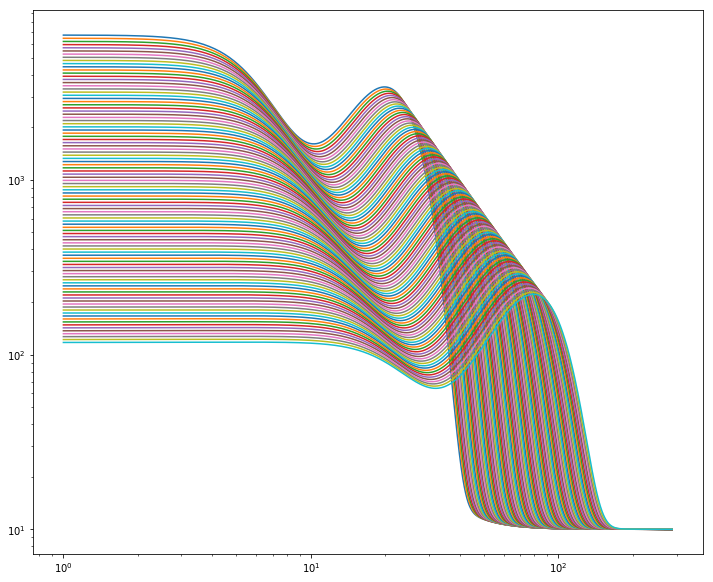

In [5]:
npts = 2880
f = np.linspace(1, 288, npts)
def harvey(f, a, b, c):
    return a**2/b / (1 + (f/b)**c)
def gaussian(f, nu, sig, height):
    return height / (2 * np.pi)**0.5 / sig * np.exp(-0.5 * (f - nu)**2 / sig**2)
def model(f, numax, white):
    h = harvey(f, 4e3/10**numax, 10**numax*0.3, 4.0)
    g = gaussian(f, 10**numax, 10**numax*0.3, 1e6/10**numax)
    return h + g + white
numaxs = np.linspace(1.3, 1.9, 100)
p = np.zeros([len(f), len(numaxs)])
fig, ax = plt.subplots()
for i in range(len(numaxs)):
    p[:,i] = model(f, numaxs[i], 10.0) #* np.random.chisquare(2, npts)/2
    ax.plot(f, p[:,i])
data = p * np.random.chisquare(2, [npts, len(numaxs)])/2
logg_nmx = numaxs + np.random.randn(len(numaxs))*0.01
ax.set_yscale('log')
ax.set_xscale('log')
print(10**numaxs)

In [6]:
code = '''
functions {
    real harvey(real f, real a, real b, real c){
        return a^2/b/(1 + (f/b)^c);
    }
    real gaussian(real f, real numax, real width, real height){
        return height * exp(-0.5 * (f - numax)^2 / width^2);
    }
}
data {
    int<lower = 0> N;
    int<lower = 0> M;
    vector[N] f;
    real<lower = 0> p[N, M];
    vector[M] numax_est;
}
parameters {
    real<lower = 1.0, upper = 2.4> numaxs[M];
    real<lower = 0, upper = 3> white[M];
    real<lower = 0, upper = 5> ahs[M];
    real<lower = 2, upper = 4> ah;
    real<lower = 0, upper = 8> bhs[M];
    real<lower = 0.1, upper = 0.6> bh;
    real<lower = 0.1, upper = 0.6> wh;
    real<lower = 0, upper = 8> hh;
    real<lower = 0, upper = 1.0> sigma_w;
    real<lower = 0, upper = 1.0> sigma_n;
    real<lower = 0, upper = 1.0> sigma_ah;
    real<lower = 0, upper = 1.0> sigma_bh;
}
transformed parameters{
    real numax[M];
    for (i in 1:M)
        numax[i] = 10^numaxs[i];
}
model {
    real tmp[N, M];
    for (j in 1:M){
        for (i in 1:N){
            tmp[i,j] = 0.5 / (gaussian(f[i], numax[j], numax[j] * wh, (10^hh)/numax[j]) 
                        + harvey(f[i], 10^ahs[j] / numax[j], numax[j] * bhs[j], 4.0) + 10^white[j]);
        }
        p[1:N, j] ~ gamma(1, tmp[1:N, j]);
    }    
    hh ~ normal(6, 0.5);
    ahs ~ normal(ah, sigma_ah);
    ah ~ normal(3.4, 0.5);
    sigma_ah ~ normal(0.0, 0.3);
    wh ~ normal(0.3, 0.1);
    bhs ~ normal(bh, sigma_bh);
    bh ~ normal(0.3, 0.1);
    sigma_bh ~ normal(0.0, 0.1);
    white ~ normal(1.0, sigma_w);
    sigma_w ~ normal(0.0, 0.3);
    numaxs ~ normal(numax_est, sigma_n);
    sigma_n ~ normal(0.0, 0.03);
}
'''
sm = pystan.StanModel(model_code=code, model_name='backfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL backfit_73573213e07f60ef55d3c9130695f422 NOW.


In [ ]:
dat = {'N': len(f),
       'M': len(numaxs),
      'f': f,
      'p': data,
      'numax_est': logg_nmx}
fit = sm.sampling(data=dat, iter=4000, chains=2)
fit.plot()

/home/davies/.local/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [ ]:
print(fit)